In [5]:
import time
import os
from os.path import join

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm

from sklearn.cluster import KMeans, DBSCAN

data_path = "/media/becode/3D_House/concrete/Positive"

In [6]:
whitelist = [4,5,6,12,13,14,15,17,18,19]
files = os.listdir(data_path)[:20]
files = list(map(lambda m: join(data_path, m), files))
files = list(filter(lambda m: m[0] in whitelist, enumerate(files)))
files = list(map(lambda m: m[1], files))
files

min_max = lambda arr: (arr.min(), arr.max())
min_rgb = lambda im: [im[...,0].min(),im[...,1].min(),im[...,2].min()]
max_rgb = lambda im: [im[...,0].max(),im[...,1].max(),im[...,2].max()]

rgb_to_grey = lambda im: np.dot(im[... , :3], [.21, .72, .07])

In [7]:
def mask_crack(im, plot=False, save:str=None, return_mask=False):
    """
    Turn input image into a mask that maps crack in concrete
    Type im can be np.array or path (str)
    Path can be passed to save generated plot
    """
    
    if type(im) == str: im = plt.imread(im)
    image = rgb_to_grey(im)
    kmeans = KMeans(4).fit_predict(image.flatten().reshape(-1,1)).reshape(image.shape)
    
    clst_values = []
    for i, clst in enumerate(np.unique(kmeans)):
        arr = np.zeros(kmeans.shape)
        arr[kmeans==clst]=1
        clst_values.append(arr)
         
    kmeans = kmeans.flatten()
    main_clst = np.array(sorted(zip(*np.unique(kmeans, return_counts=True)), key=lambda i:i[1]))[-2:,0]

    crack_mask = np.ones(image.shape)
    for cluster_idxs in main_clst: crack_mask -= clst_values[cluster_idxs]

    crack_xy = np.array(list(zip(*crack_mask.nonzero())))
    crack_dbscan = DBSCAN(eps=1).fit(crack_xy)

    main_clst = sorted(zip(*np.unique(crack_dbscan.labels_, return_counts=True)), key=lambda i:i[1])[-1][0]

    dbscan_xy = np.array(list(map(lambda x: x[0], 
        filter(lambda x: x[1]==main_clst, 
               zip(crack_xy, crack_dbscan.labels_)))))

    result = np.zeros(image.shape)
    for idxy in dbscan_xy: result[idxy[0], idxy[1]]=1
        
    bounds_x = min_max(np.array(list(zip(*np.nonzero(result))))[:,1])
    bounds_y = min_max(np.array(list(zip(*np.nonzero(result))))[:,0])
    surface = result.sum().astype(int)

    plt.imshow(result)
    plt.plot(
        [bounds_x[0],bounds_x[1],bounds_x[1],bounds_x[0],bounds_x[0]],
        [bounds_y[0],bounds_y[0],bounds_y[1],bounds_y[1],bounds_y[0]],
        c="r", linewidth=4)
    plt.text(75, 110, f"{round(surface/100, 1)} cm²", color="w", fontsize=16)
    
    if save: plt.savefig(save)
    if not plot: plt.close()
    
    if return_mask: return result

In [133]:
idx = 0

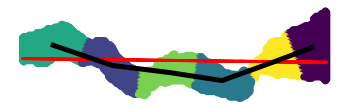

In [140]:
mask = mask_crack(plt.imread(join(data_path, files[idx])), return_mask=True)

bounds_x = min_max(np.array(list(zip(*np.nonzero(mask))))[:,1])
bounds_y = min_max(np.array(list(zip(*np.nonzero(mask))))[:,0])

distance1d = lambda bounds: bounds[1] - bounds[0]
width, height = distance1d(bounds_x), distance1d(bounds_y)
ratio = width/height

data = np.array(list(zip(*np.nonzero(mask)))).T
y, x = data
m, b = np.polyfit(x, y, 1)

kmeans = KMeans(6).fit(data.T)
centroids = np.array(sorted(kmeans.cluster_centers_[...,::-1], key=lambda i:i[0]))

plt.scatter(x=x, y=y, c=kmeans.labels_)

plt.plot(x, m*x +b, c="r", linewidth=3)
plt.plot(*centroids.T, c="k", linewidth=5)

ax = plt.gca()
ax.set_axis_off()
ax.set_ylim(ax.get_ylim()[::-1])
plt.axis('scaled')
plt.show()

idx += 1

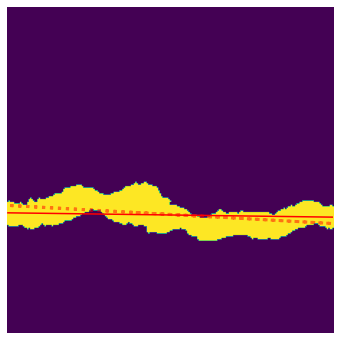

In [106]:
plt.figure(figsize=(6,6))
plt.imshow(mask)

start = [0, np.median(np.nonzero(mask[:,0])).astype(int)]
finish = [mask.shape[1]-1, np.median(np.nonzero(mask[:,-1])).astype(int)]

plt.plot(*list(zip(start, finish)), c="r")
plt.plot(x, m*x +b, c="r", linewidth=3, linestyle="dotted", alpha=.5)

ax = plt.gca()
ax.set_axis_off()
plt.axis('scaled')
plt.show()

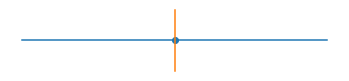

In [47]:
x, y = [0,1], [.5,.5]
plt.plot(x, y)

calc_slope = lambda x, y: [np.diff(y)/np.diff(x)][0]
calc_center = lambda x, y: [(x[0]+x[1])/2, (y[0]+y[1])/2]

center = calc_center(x, y)
slope = calc_slope(x, y)

tan_len = .1
dy = (tan_len**2/(slope**2+1))**.5
dx = -slope*dy
perp_a = [center[0] + dx, center[0] - dx]
perp_b = [center[1] + dy, center[1] - dy]

plt.scatter(*center)
plt.plot(perp_a, perp_b)
plt.gca().set_axis_off()
plt.axis('scaled')
plt.show()

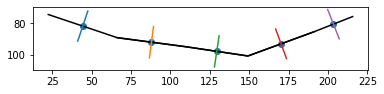

In [54]:
lines_x = [[centroids[i,0],centroids[i+1,0]] for i, _ in enumerate(centroids[:-1,0])]
lines_y = [[centroids[i,1],centroids[i+1,1]] for i, _ in enumerate(centroids[:-1,1])]

plt.plot(lines_x, lines_y, "k")
slopes = list(map(lambda x: x, np.diff(lines_y)/np.diff(lines_x)))
centers = np.array(list(map(lambda x: calc_center(*x), list(zip(lines_x, lines_y)))))

for i in range(len(slopes)):
    dy = (10**2/(slopes[i]**2+1))**.5
    dx = -slopes[i]*dy
    perp_x = [centers[i][0] + dx, centers[i][0] - dx]
    perp_y = [centers[i][1] + dy, centers[i][1] - dy]
    plt.plot(perp_x, perp_y)

plt.scatter(*centers.T)

ax = plt.gca()
ax.set_ylim(ax.get_ylim()[::-1])
plt.axis('scaled')
plt.show()

In [74]:
idx = 0

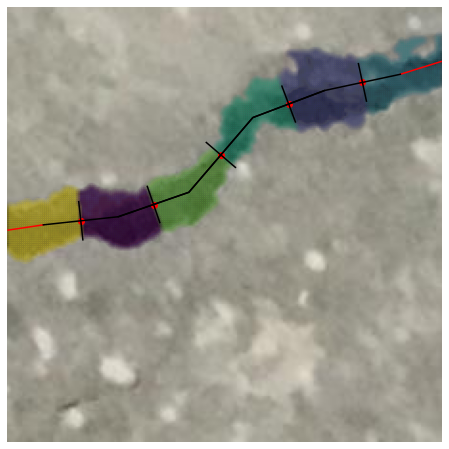

In [75]:
im = plt.imread(files[idx])
mask = mask_crack(im, return_mask=True)

plt.figure(figsize=(8,8))
plt.imshow(im)

bounds_x = min_max(np.array(list(zip(*np.nonzero(mask))))[:,1])
bounds_y = min_max(np.array(list(zip(*np.nonzero(mask))))[:,0])

distance1d = lambda bounds: bounds[1] - bounds[0]
width, height = distance1d(bounds_x), distance1d(bounds_y)
ratio = width/height

data = np.array(list(zip(*np.nonzero(mask)))).T
y, x = data
m, b = np.polyfit(x, y, 1)

kmeans = KMeans(6).fit(data.T)
centroids = np.array(sorted(kmeans.cluster_centers_[...,::-1], key=lambda i:i[0]))

plt.scatter(x=x, y=y, c=kmeans.labels_, alpha=.05)

lines_x = [[centroids[i,0],centroids[i+1,0]] for i, _ in enumerate(centroids[:-1,0])]
lines_y = [[centroids[i,1],centroids[i+1,1]] for i, _ in enumerate(centroids[:-1,1])]

start = [0, np.median(np.nonzero(mask[:,0])).astype(int)]
finish = [mask.shape[1]-1, np.median(np.nonzero(mask[:,-1])).astype(int)]
plt.plot([start[0], lines_x[0][0]], [start[1], lines_y[0][0]], c="r")
plt.plot([finish[0], lines_x[-1][-1]], [finish[1], lines_y[-1][-1]], c="r")
plt.plot(lines_x, lines_y, "k")

slopes = list(map(lambda x: x, np.diff(lines_y)/np.diff(lines_x)))
centers = np.array(list(map(lambda x: calc_center(*x), list(zip(lines_x, lines_y)))))

tan_len=10
for i in range(len(slopes)):
    dy = (tan_len**2/(slopes[i]**2+1))**.5
    dx = -slopes[i]*dy
    perp_x = [centers[i][0] + dx, centers[i][0] - dx]
    perp_y = [centers[i][1] + dy, centers[i][1] - dy]
    plt.plot(perp_x, perp_y, c="k")

plt.scatter(*centers.T, c="r")

ax = plt.gca()
ax.set_axis_off()
ax.set_ylim(ax.get_ylim()[::-1])

plt.axis('scaled')
plt.show()

In [168]:
idx = 0

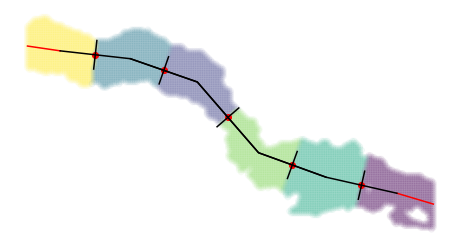

In [169]:
im = plt.imread(files[idx])
mask = mask_crack(im, return_mask=True)

plt.figure(figsize=(8,8))
#plt.imshow(im)

bounds_x = min_max(np.array(list(zip(*np.nonzero(mask))))[:,1])
bounds_y = min_max(np.array(list(zip(*np.nonzero(mask))))[:,0])

distance1d = lambda bounds: bounds[1] - bounds[0]
width, height = distance1d(bounds_x), distance1d(bounds_y)
ratio = width/height

data = np.array(list(zip(*np.nonzero(mask)))).T
y, x = data
m, b = np.polyfit(x, y, 1)

kmeans = KMeans(6).fit(data.T)
centroids = np.array(sorted(kmeans.cluster_centers_[...,::-1], key=lambda i:i[0]))

plt.scatter(x=x, y=y, c=kmeans.labels_, alpha=.05)

lines_x = [[centroids[i,0],centroids[i+1,0]] for i, _ in enumerate(centroids[:-1,0])]
lines_y = [[centroids[i,1],centroids[i+1,1]] for i, _ in enumerate(centroids[:-1,1])]

start = [0, np.median(np.nonzero(mask[:,0])).astype(int)]
finish = [mask.shape[1]-1, np.median(np.nonzero(mask[:,-1])).astype(int)]
plt.plot([start[0], lines_x[0][0]], [start[1], lines_y[0][0]], c="r")
plt.plot([finish[0], lines_x[-1][-1]], [finish[1], lines_y[-1][-1]], c="r")
plt.plot(lines_x, lines_y, "k")

slopes = list(map(lambda x: x, np.diff(lines_y)/np.diff(lines_x)))
centers = np.array(list(map(lambda x: calc_center(*x), list(zip(lines_x, lines_y)))))

tan_len=8
for i in range(len(slopes)):
    dy = (tan_len**2/(slopes[i]**2+1))**.5
    dx = -slopes[i]*dy
    perp_x = [centers[i][0] + dx, centers[i][0] - dx]
    perp_y = [centers[i][1] + dy, centers[i][1] - dy]
    plt.plot(perp_x, perp_y, c="k")

plt.scatter(*centers.T, c="r")

ax = plt.gca()
ax.set_axis_off()
ax.set_ylim(ax.get_ylim()[::-1])

plt.axis('scaled')
plt.show()
idx += 1

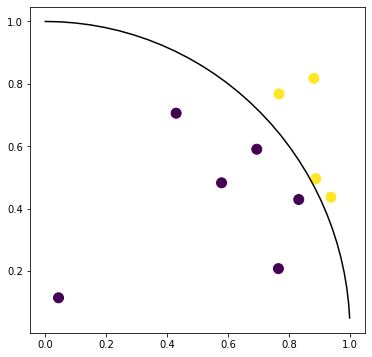

In [43]:
import math
verts = []
radius = 1
count = 32
delta = 2 * math.pi / count  / 4
theta = 0.0
for i in range(count):
    theta += delta
    verts.append((radius * math.cos(theta), radius * math.sin(theta)))
    
plt.figure(figsize=(6,6))
points=np.array([np.random.random(10), np.random.random(10)])
distance=list(map(lambda m: sum(m**2), points.T))
plt.scatter(*points, c=list(map(lambda m: m >= 1, distance)), s=100)
plt.plot(*list(zip(*verts)), c="k")

In [41]:
def draw_circle(point=[0,0], radius=1, count=32):
    delta = 2 * math.pi / count
    theta = 0.0
    result = []
    for i in range(count):
        theta += delta
        result.append(
            (radius * math.cos(theta) +point[0],
             radius * math.sin(theta) +point[1])
        )
        
    return np.append(result, [result[0]], axis=0).T

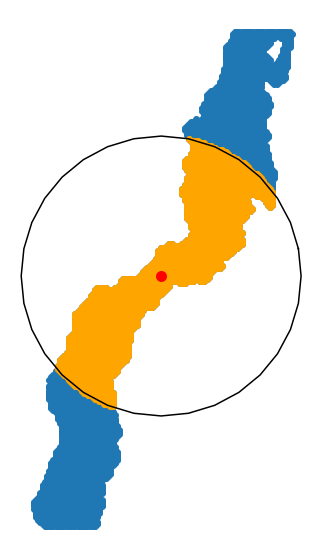

In [170]:
plt.figure(figsize=(10,10))
plt.scatter(*data)

radius = 64
centroid = np.mean(data.T, axis=0)
plt.plot(*draw_circle(centroid, radius), c="k")

xy, rad = centroid, radius

plt.scatter(*np.array(list(filter(
    lambda p: np.linalg.norm(p -xy) <= rad, data.T))).T, c="orange")
plt.scatter(centroid[0], centroid[1], c="r", s=100)

plt.axis("scaled")
plt.gca().set_axis_off()

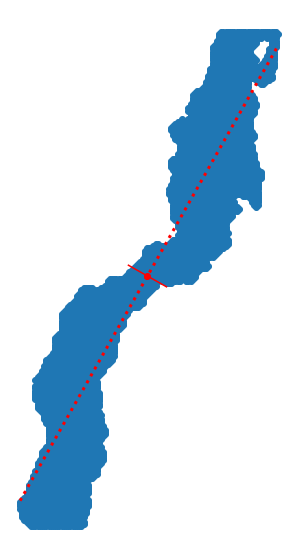

In [171]:
plt.figure(figsize=(10,10))

center=np.mean(data.T, axis=0)
plt.scatter(*data)
plt.scatter(*center, c="r")

(x, y), (m, b) = data, np.polyfit(*data, 1)
plt.plot(x, m*x +b, c="r", linewidth=3, linestyle="dotted")
slope=m

tan_len = 10
dy = (tan_len**2/(slope**2+1))**.5
dx = -slope*dy
perp_a = [center[0] + dx, center[0] - dx]
perp_b = [center[1] + dy, center[1] - dy]
plt.plot(perp_a, perp_b, c="r")

plt.axis("scaled")
plt.gca().set_axis_off()

0.43697190284729004


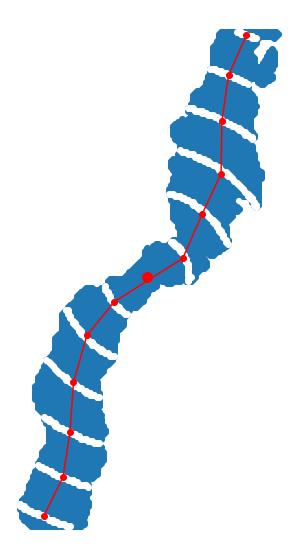

In [26]:
start = time.time()
plt.figure(figsize=(10,10))
plt.scatter(*data)

xy = np.mean(data.T, axis=0)

points = []
for radius in [20,40,60,80,100, 120]:
    rad = radius
    ring_xy = np.array(list(filter(
        lambda p: rad-1 < np.linalg.norm(p -xy) <= rad, data.T)))
    if len(ring_xy) == 0: break
        
    dbscan = DBSCAN(5).fit_predict(ring_xy)
    plt.scatter(*ring_xy.T, c="w")
    
    if len(set(dbscan)) < 2:
        points.append(list(np.mean(ring_xy, axis=0)))
        continue
    
    points.append(list(np.mean(ring_xy[dbscan==0], axis=0)))
    plt.scatter(*points[-1], c="r")
    points.append(list(np.mean(ring_xy[dbscan==1], axis=0)))
    plt.scatter(*points[-1], c="r")
    
plt.plot(*np.array(sorted(points,key=lambda i:i[0])).T, c="r")
plt.scatter(*xy, c="r", s=100)

plt.axis("scaled")
plt.gca().set_axis_off()
print(time.time() -start)

In [ ]:
lambda p: rad-1 < np.linalg.norm(p -xy) <= rad, data.T

6703


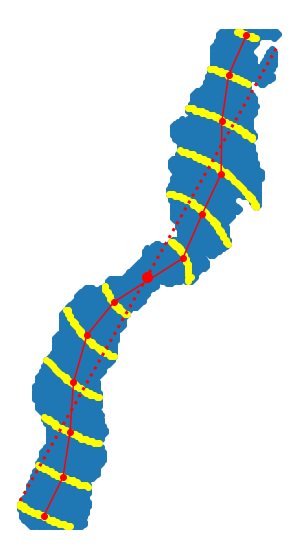

3531


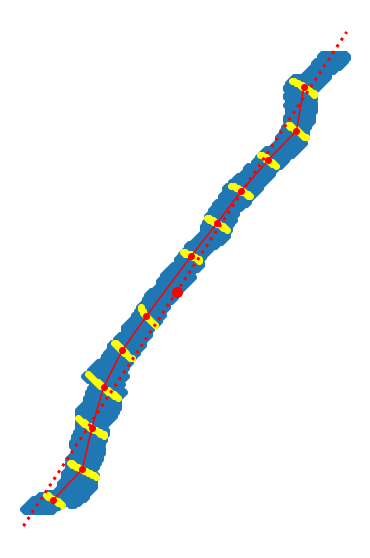

9361


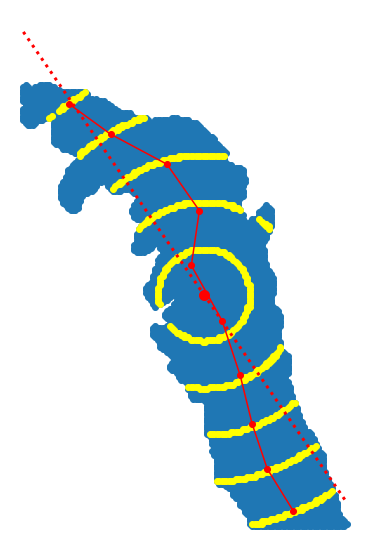

7386


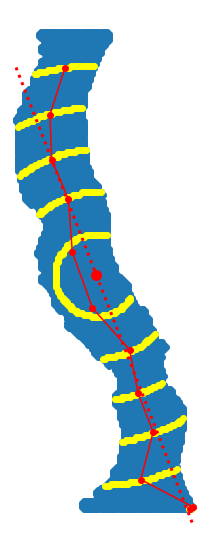

3404


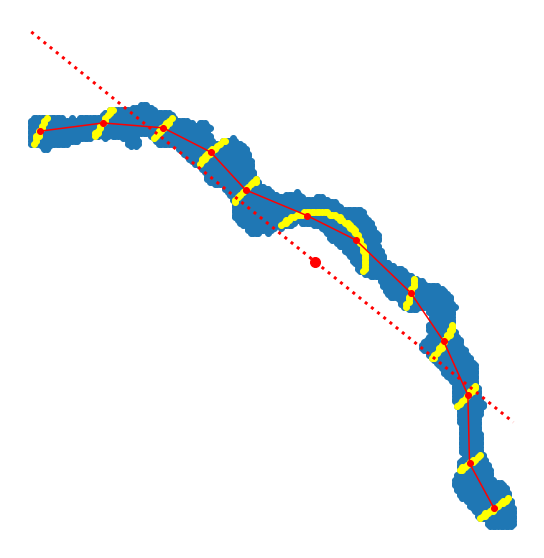

4133


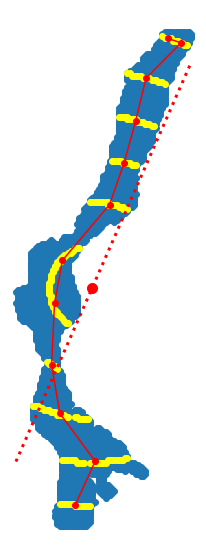

5174


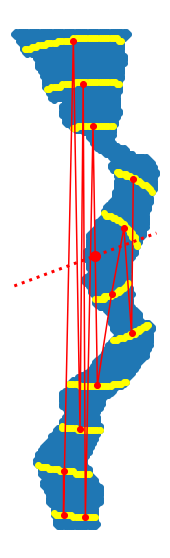

3474


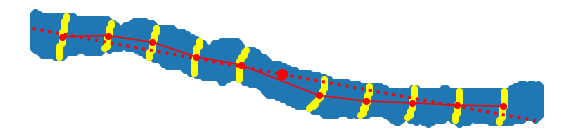

3619


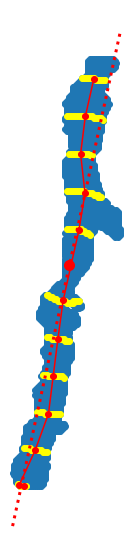

4368


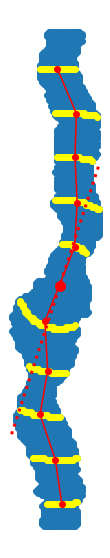

In [172]:
#for file in os.listdir(data_path)[:20]:
for file in files:
    im = plt.imread(join(data_path, file))
    mask = mask_crack(im, return_mask=True)
    data = np.array(list(zip(*np.nonzero(mask)))).T
    
    plt.figure(figsize=(10,10))
    plt.scatter(*data)

    xy = np.mean(data.T, axis=0)
    
    (x, y), (m, b) = data, np.polyfit(*data, 1)
    print(len(x))
    plt.plot(x, m*x +b, c="r", linewidth=3, linestyle="dotted")
    
    points = []
    for radius in [20,40,60,80,100,120]:
        rad = radius
        ring_xy = np.array(list(filter(
            lambda p: rad-1 < np.linalg.norm(p -xy) <= rad, data.T)))
        if len(ring_xy) == 0: break

        dbscan = KMeans(n_clusters=2).fit_predict(ring_xy)
        #dbscan = DBSCAN(eps=5).fit_predict(ring_xy)
        plt.scatter(*ring_xy.T, c="yellow")

        if len(set(dbscan)) < 2:
            points.append(list(np.mean(ring_xy, axis=0)))
            continue

        points.append(list(np.mean(ring_xy[dbscan==0], axis=0)))
        plt.scatter(*points[-1], c="r")
        points.append(list(np.mean(ring_xy[dbscan==1], axis=0)))
        plt.scatter(*points[-1], c="r")

    plt.plot(*np.array(sorted(points,key=lambda i:i[0 if -1 < m < 1 else 1])).T, c="r")
    plt.scatter(*xy, c="r", s=100)

    plt.axis("scaled")
    plt.gca().set_axis_off()
    #plt.title(f"Slope: {round(m, 2)}\nY-cept: {int(b)}", fontsize=16)
    plt.show()

In [ ]:
plt.figure(figsize=(6,6))
data_xy = np.array([np.random.random(1000),np.random.random(1000)])
xy, rad = [.5, .5], .5

plt.scatter(*data_xy, c="grey")
plt.scatter(*xy, c="r", s=1000)
plt.scatter(*xy, c="k", s=100)
plt.plot(*draw_circle(xy, rad), c="k", linewidth=3)
plt.plot(*draw_circle(xy, rad -.1), c="k")

ring_xy = np.array(list(filter(
    lambda f: rad-.1 < ((xy[0]-f[0])**2+(xy[1]-f[1])**2)**.5 <= rad, data_xy.T))).T

kmeans = KMeans().fit_predict(ring_xy.T)
plt.scatter(*ring_xy, c=kmeans)
plt.title(dict(zip(*np.unique(kmeans, return_counts=True))))
plt.show()